# Шаг 1. Подготовка окружения и импорт необходимых библиотек

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import math

# Шаг 2. Импорт данных

Все три файла содержат числовые данные, сгенерированные по разным распределениям.  
Загружаем их в цикле, обрабатываем возможные ошибки (отсутствие файла, некорректный формат).


In [ ]:
def load_single_line_csv(filename: str) -> pd.DataFrame:
    """
    Загружает CSV-файл, в котором все значения лежат в одной строке,
    разделённые запятыми.
    """
    try:
        with open(filename, "r", encoding="utf-8") as f:
            line = f.readline().strip()
    except FileNotFoundError:
        print(f"Файл '{filename}' не найден.")
        return pd.DataFrame()

    try:
        values = [float(x) for x in line.split(",")]
    except ValueError as e:
        print(f"Некорректный формат данных в '{filename}': {e}")
        return pd.DataFrame()

    return pd.DataFrame(values, columns=["Value"])

# Список файлов
files = ["set_1.csv", "set_2.csv", "set_3.csv"]
dfs = {}

# Загрузка данных из файлов
for file in files:
    df = load_single_line_csv(file)
    if df.empty:
        print(f"Предупреждение: '{file}' не был загружен или пуст.")
    else:
        dfs[file] = df
        print(f"Файл '{file}' загружен. Кол-во значений: {len(df)}")

# Краткий просмотр первых строк каждого датасета
for filename, df in dfs.items():
    print(f"\n=== {filename} ===")
    print(df.head(3))
    print("-" * 30)

Файл 'set_1.csv' загружен. Кол-во значений: 100000
Файл 'set_2.csv' загружен. Кол-во значений: 10000
Файл 'set_3.csv' загружен. Кол-во значений: 100000

=== set_1.csv ===
   Value
0    3.0
1    1.0
2    1.0
------------------------------

=== set_2.csv ===
       Value
0  90.547448
1  80.548716
2  92.992958
------------------------------

=== set_3.csv ===
      Value
0  0.002163
1  0.023507
2  0.067606
------------------------------


# Шаг 3. Анализ данных (математическое ожидание и дисперсия)

Задачи:
1. Реализовать функции для расчёта математического ожидания (Mean) и дисперсии (Variance) **без** использования готовых методов `.mean()`/`.var()` или специализированных библиотек.
2. Применить их к каждому набору данных и вывести результаты

In [3]:
def calculate_mean(data):
    """
    Вычисляет среднее арифметическое (мат. ожидание)
    для списка/Series чисел, не используя готовые mean() / var().
    """
    total = 0.0
    n = 0
    for x in data:
        total += x
        n += 1
    return total / n if n else 0

def calculate_variance(data):
    """
    Вычисляет генеральную дисперсию:
      σ² = (1/n) * Σ (xᵢ - μ)².
    """
    mean_val = calculate_mean(data)
    s = 0.0
    n = 0
    for x in data:
        s += (x - mean_val) ** 2
        n += 1
    return s / n if n else 0

# Создадим списки datasets и mean_variance для удобного использования
datasets = []
mean_variance = []

print("\nРезультаты анализа (Mean и Variance):")
for file in files:
    if file in dfs:
        values = dfs[file]["Value"]
        m = calculate_mean(values)
        v = calculate_variance(values)
        datasets.append(values)           # сохраняем сами данные
        mean_variance.append((m, v))      # сохраняем кортеж (mean, variance)
        print(f"{file}: Mean = {m:.4f}, Variance = {v:.4f}")
    else:
        # Если файл не был загружен
        datasets.append([])
        mean_variance.append((0, 0))
        print(f"{file}: Данные отсутствуют.")


Результаты анализа (Mean и Variance):
set_1.csv: Mean = 3.4408, Variance = 10.0482
set_2.csv: Mean = 16.2433, Variance = 10927.4046
set_3.csv: Mean = 0.1245, Variance = 0.0256


# Шаг 4. Обнаружение и удаление выбросов

Существует несколько методов для обработки выбросов:
- **Z-оценка (Z-score):** удаляет наблюдения, у которых отклонение от среднего больше, чем заданное число стандартных отклонений.
- **IQR (Interquartile Range):** оставляет данные, лежащие в интервале [Q1 - k·IQR, Q3 + k·IQR].
- **Тримминг (обрезка по процентилям):** отбраковывает значения, попадающие ниже и выше заданных процентилей (например, 5% и 95%).
- **Винзоризация:** заменяет значения, выходящие за указанные процентильные границы, на граничные значения (размер выборки остаётся неизменным).
- **MAD (Медианное абсолютное отклонение):** рассчитывает модифицированные Z-оценки на основе медианы и MAD; оставляются наблюдения с модифицированной Z-оценкой по модулю ≤ threshold.

Ниже приведён код, реализующий все методы, функцию для построения гистограммы и цикл для применения каждого метода к каждому датасету.


In [4]:
def remove_outliers_zscore(df, column="Value", threshold=3.0):
    """
    Удаляет наблюдения, у которых отклонение от среднего больше threshold * std.
    """
    mean_val = df[column].mean()
    std_val = df[column].std()
    return df[(df[column] - mean_val).abs() <= threshold * std_val]

def remove_outliers_iqr(df, column="Value", k=1.5):
    """
    Оставляет наблюдения, лежащие в интервале [Q1 - k·IQR, Q3 + k·IQR].
    """
    Q1 = df[column].quantile(0.25)
    Q3 = df[column].quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - k * IQR
    upper_bound = Q3 + k * IQR
    return df[(df[column] >= lower_bound) & (df[column] <= upper_bound)]

def remove_outliers_trimming(df, column="Value", lower_percentile=0.05, upper_percentile=0.95):
    """
    Удаляет наблюдения, которые находятся ниже нижнего или выше верхнего процентиля.
    """
    lower_bound = df[column].quantile(lower_percentile)
    upper_bound = df[column].quantile(upper_percentile)
    return df[(df[column] >= lower_bound) & (df[column] <= upper_bound)]

def winsorize_outliers(df, column="Value", lower_percentile=0.05, upper_percentile=0.95):
    """
    Заменяет значения, выходящие за границы [lower_percentile, upper_percentile],
    на соответствующие граничные значения.
    """
    lower_bound = df[column].quantile(lower_percentile)
    upper_bound = df[column].quantile(upper_percentile)
    df_winsorized = df.copy()
    df_winsorized.loc[df_winsorized[column] < lower_bound, column] = lower_bound
    df_winsorized.loc[df_winsorized[column] > upper_bound, column] = upper_bound
    return df_winsorized

def remove_outliers_mad(df, column="Value", threshold=3.5):
    """
    Удаляет наблюдения, для которых модифицированная Z-оценка (на основе медианы и MAD)
    превышает threshold по модулю.
    """
    median_val = df[column].median()
    mad = (df[column] - median_val).abs().median()
    if mad == 0:
        return df
    modified_z = 0.6745 * (df[column] - median_val) / mad
    return df[modified_z.abs() <= threshold]

methods = {
    "Z-оценка": remove_outliers_zscore,
    "IQR": remove_outliers_iqr,
    "Тримминг": remove_outliers_trimming,
    "Винзоризация": winsorize_outliers,
    "MAD": remove_outliers_mad
}

# Шаг 5. Построение гистограмм с использованием правила Стёрджеса

Для построения гистограмм необходимо определить оптимальное число интервалов.  
Мы используем **правило Стёрджеса**, которое вычисляет число корзин по формуле:

$$
\text{bins} = \lceil 1 + \log_2(n) \rceil,
$$

где $n$ — число наблюдений.

Далее с помощью matplotlib строим гистограммы, нормированные так, что сумма высот столбцов равна 100%,  
то есть каждому наблюдению соответствует вклад $100 / n$.



Обработка выбросов: set_1.csv
  Z-оценка: 98297 наблюдений


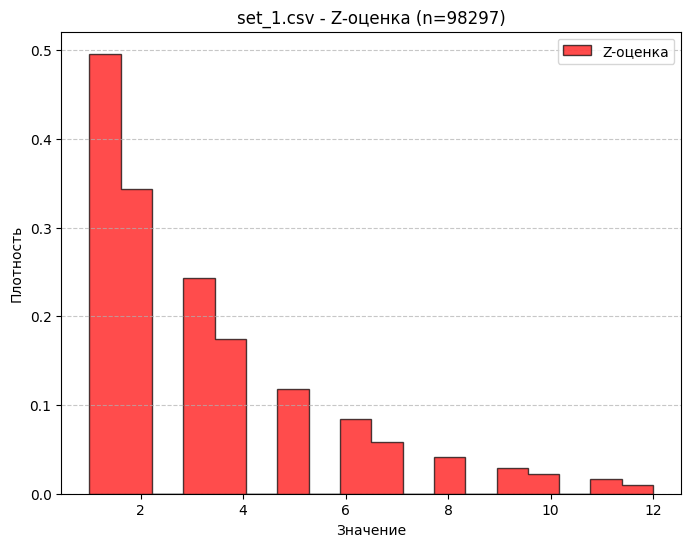

  IQR: 93685 наблюдений


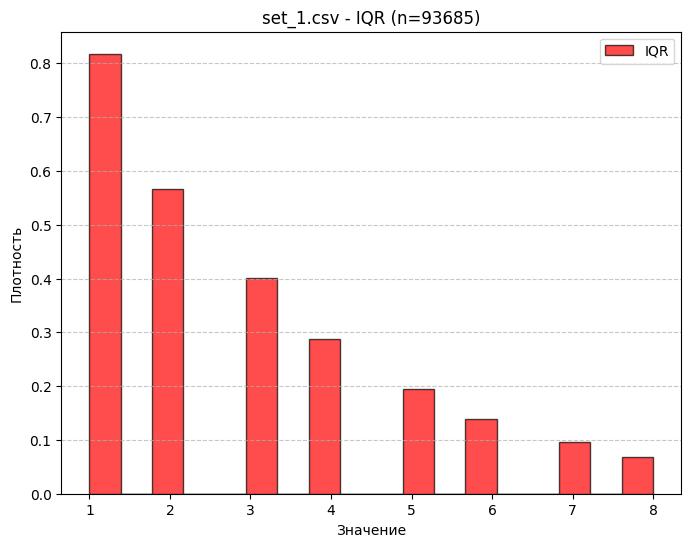

  Тримминг: 95404 наблюдений


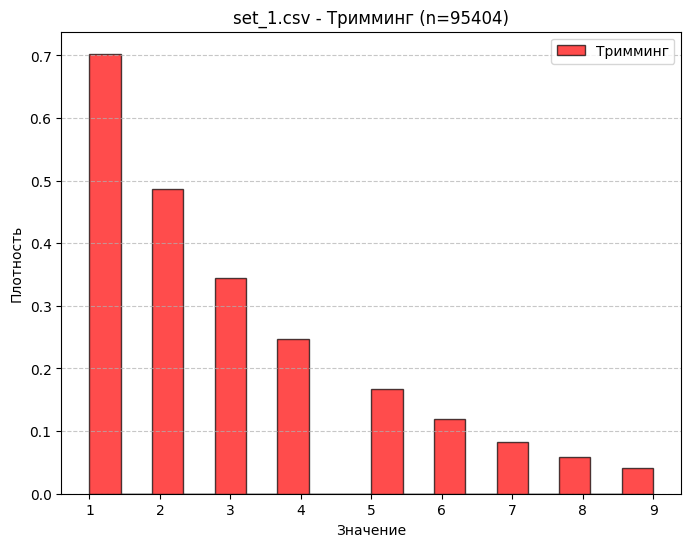

  Винзоризация: 100000 наблюдений


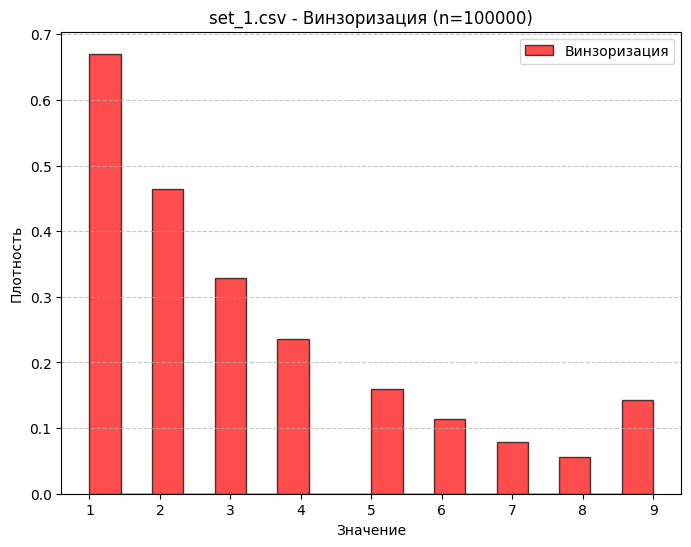

  MAD: 91216 наблюдений


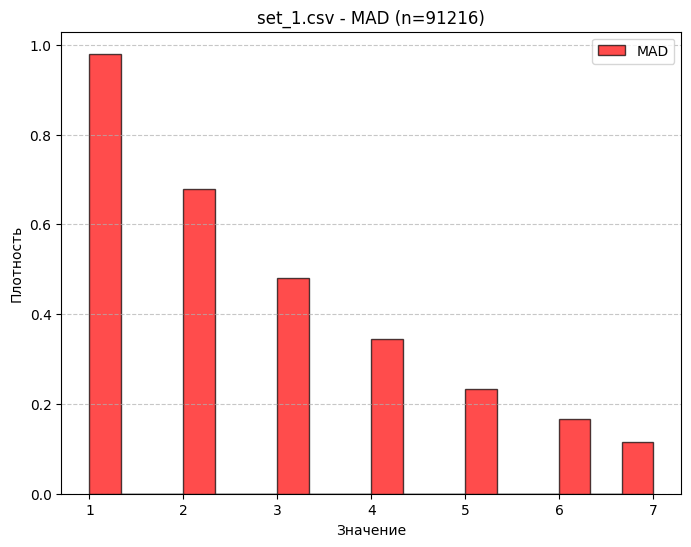


Обработка выбросов: set_2.csv
  Z-оценка: 9866 наблюдений


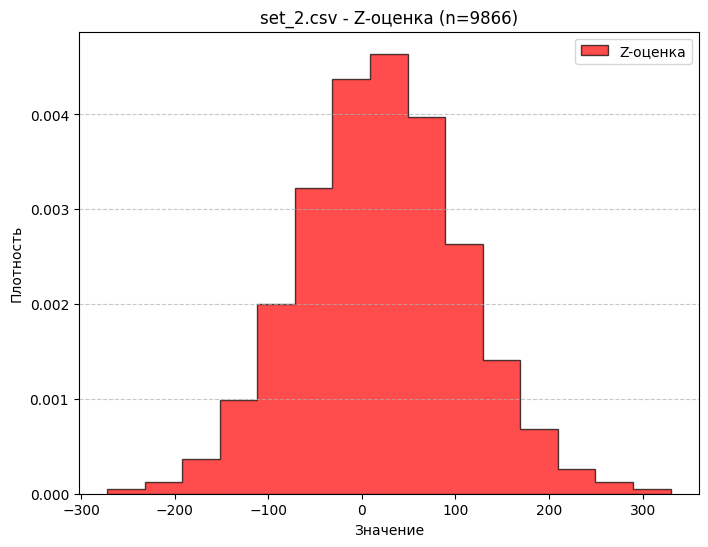

  IQR: 9763 наблюдений


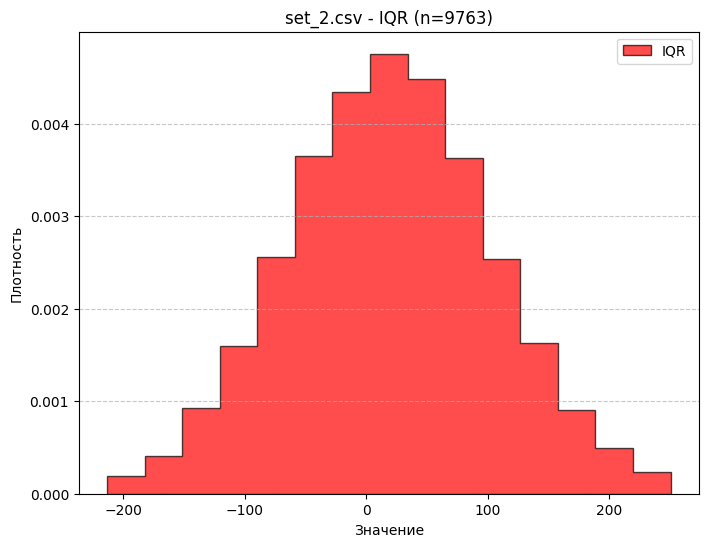

  Тримминг: 9000 наблюдений


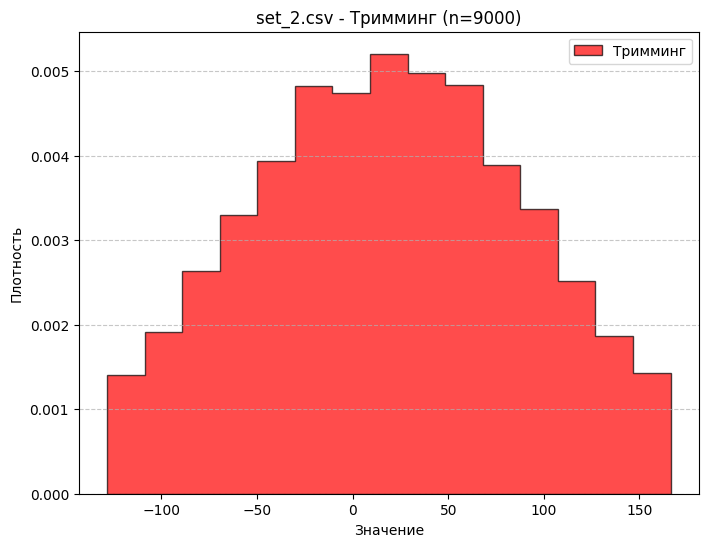

  Винзоризация: 10000 наблюдений


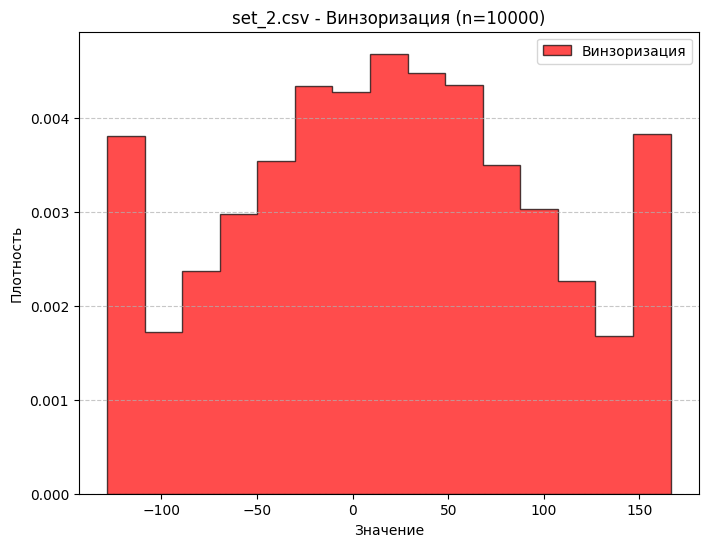

  MAD: 9861 наблюдений


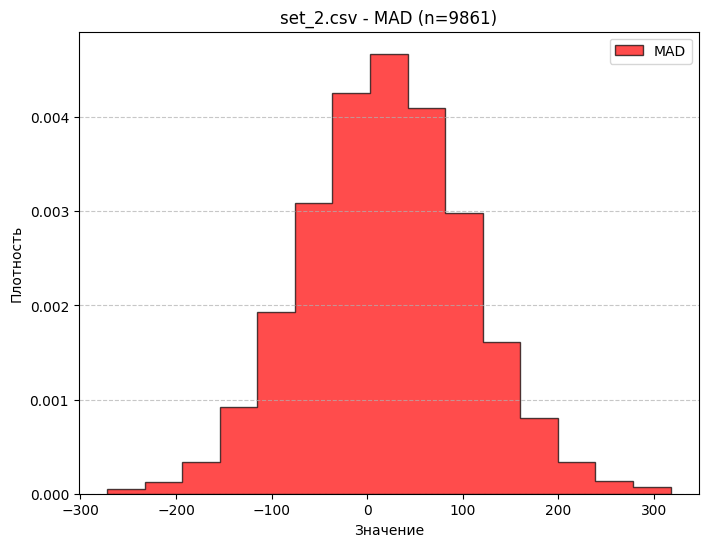


Обработка выбросов: set_3.csv
  Z-оценка: 98252 наблюдений


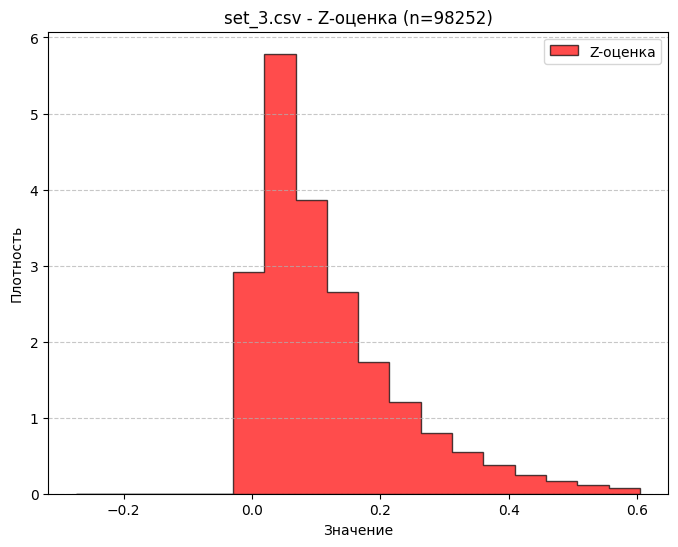

  IQR: 94317 наблюдений


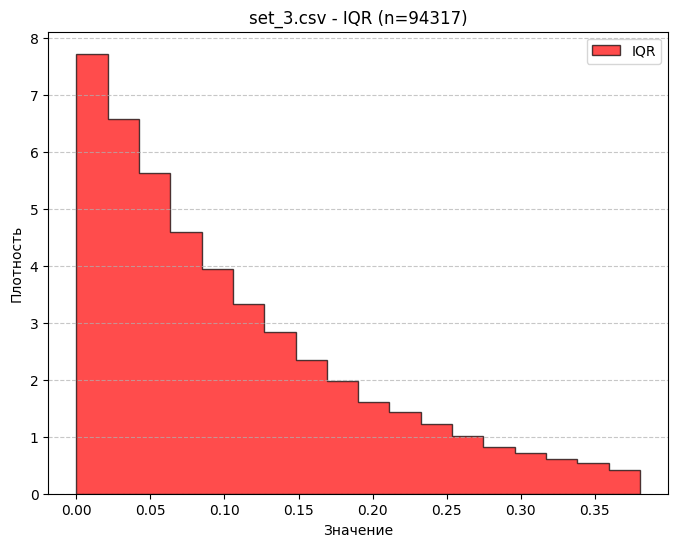

  Тримминг: 90000 наблюдений


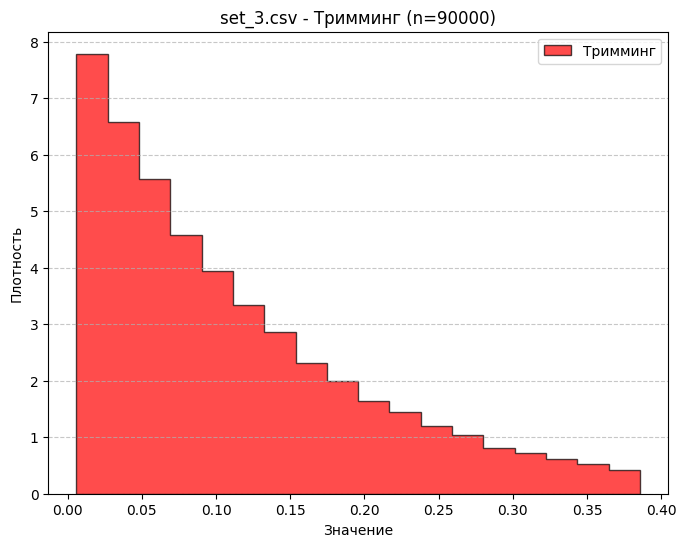

  Винзоризация: 100000 наблюдений


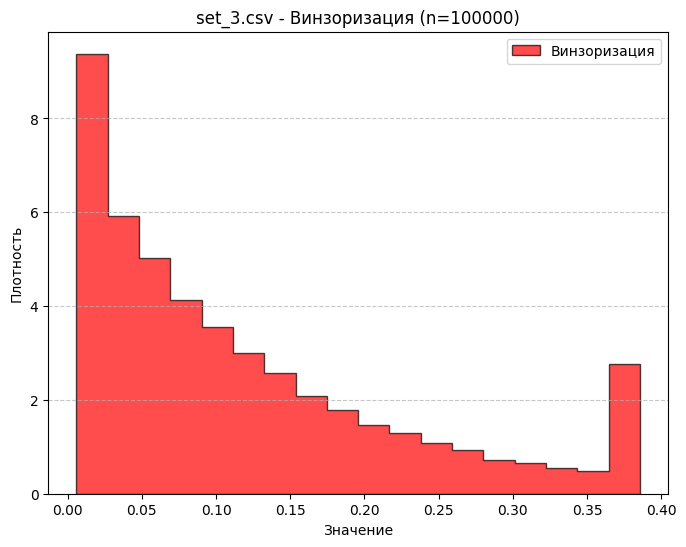

  MAD: 94981 наблюдений


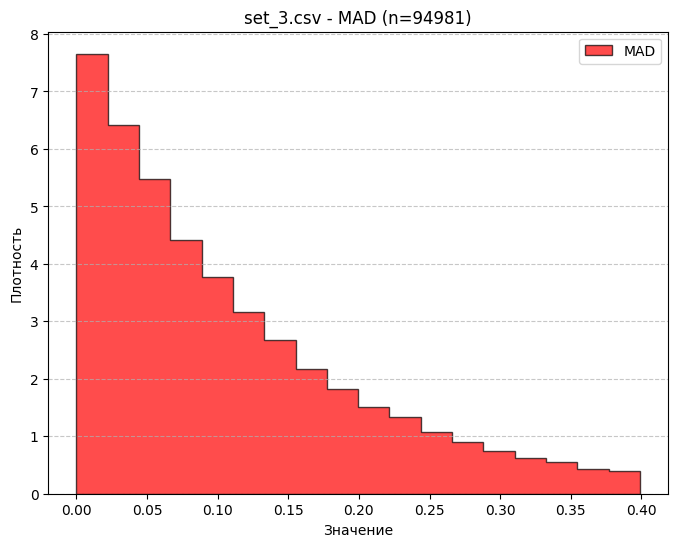

In [ ]:
def calculate_bins_sturges(data):
    """
    Правило Стёрджеса: bins = ceil(1 + log2(n)).
    """
    n = len(data)
    if n == 0:
        return 1
    return math.ceil(1 + math.log2(n))

def plot_multi_histograms(data_list, title, labels=None, alpha_list=None, colors=None):
    """
    Строит одну или несколько наложенных гистограмм в общем стиле.
    """
    import numpy as np
    import matplotlib.pyplot as plt

    if labels is None:
        labels = [f"Data {i+1}" for i in range(len(data_list))]
    if alpha_list is None:
        alpha_list = [0.7] * len(data_list)

    if colors is None:
        colors = ["#FF0000", "#00FF00"]

    # Фильтруем пустые массивы
    non_empty_data = []
    non_empty_labels = []
    non_empty_alphas = []
    for d, lbl, a in zip(data_list, labels, alpha_list):
        arr = np.array(d)
        if len(arr) > 0:
            non_empty_data.append(arr)
            non_empty_labels.append(lbl)
            non_empty_alphas.append(a)
        else:
            print(f"Пропуск пустого набора: {lbl}")

    if len(non_empty_data) == 0:
        print(f"{title}: все наборы данных пустые, пропуск построения графика.")
        return

    # Объединяем все данные, чтобы вычислить общее число корзин
    all_data = np.concatenate(non_empty_data)
    bins_count = calculate_bins_sturges(all_data)
    bins_min, bins_max = all_data.min(), all_data.max()
    bins = np.linspace(bins_min, bins_max, bins_count + 1)

    plt.figure(figsize=(8, 6))

    # Строим гистограммы
    for i, arr in enumerate(non_empty_data):
        # Определяем цвет
        c = colors[i % len(colors)]
        a = non_empty_alphas[i]

        plt.hist(
            arr,
            bins=bins,
            density=True,
            alpha=a,
            color=c,
            edgecolor="black",
            label=non_empty_labels[i],
            histtype="stepfilled"
        )

    plt.title(title)
    plt.xlabel("Значение")
    plt.ylabel("Плотность")
    plt.legend()
    plt.grid(axis="y", linestyle="--", alpha=0.7)
    plt.show()

# Применение методов очистки и построение гистограмм для каждого
# набора данных (одиночная гистограмма)

for fname, df in dfs.items():
    print(f"\nОбработка выбросов: {fname}")
    for method_name, method_func in methods.items():
        cleaned_df = method_func(df)
        n_obs = len(cleaned_df)
        title = f"{fname} - {method_name} (n={n_obs})"
        print(f"  {method_name}: {n_obs} наблюдений")

        plot_multi_histograms(
            data_list=[cleaned_df["Value"]],
            title=title,
            labels=[method_name],
            alpha_list=[0.7],
        )

# Шаг 6 Построение теорических распределений

**Геометрическое распределение:**

<div align="left">
$$ P(X=k) = p\,(1-p)^{k-1}, \quad p = \frac{1}{\text{mean}} $$
</div>

**Биномиальное распределение:**

<div align="left">
$$ P(X=k) = \binom{n}{k}\, p^k (1-p)^{n-k}, \quad p = 1 - \frac{\text{variance}}{\text{mean}}, \quad n = \text{round}\!\left(\frac{\text{mean}}{p}\right) $$
</div>

**Распределение Пуассона:**

<div align="left">
$$ P(X=k) = \frac{\lambda^k e^{-\lambda}}{k!}, \quad \lambda = \text{mean} $$
</div>

**Равномерное распределение:**

<div align="left">
$$ f(x) = \frac{1}{b-a}, \quad a = \text{mean} - \sqrt{3\,\text{variance}}, \quad b = \text{mean} + \sqrt{3\,\text{variance}} $$
</div>

**Нормальное распределение:**

<div align="left">
$$ f(x) = \frac{1}{\sqrt{2\pi}\,\sigma}\, \exp\!\left(-\frac{(x-\text{mean})^2}{2\,\text{variance}}\right), \quad \sigma^2 = \text{variance} $$
</div>

**Экспоненциальное распределение:**

<div align="left">
$$ f(x) = \lambda\, \exp(-\lambda x) \quad \text{for } x \ge 0, \quad \lambda = \frac{1}{\text{mean}} $$
</div>



Сравнение с теоретическими распределениями (одиночные гистограммы):

set_1.csv: Эмпирические параметры - mean = 3.4408, variance = 10.0483
  Geometric: 10000 значений сгенерировано.


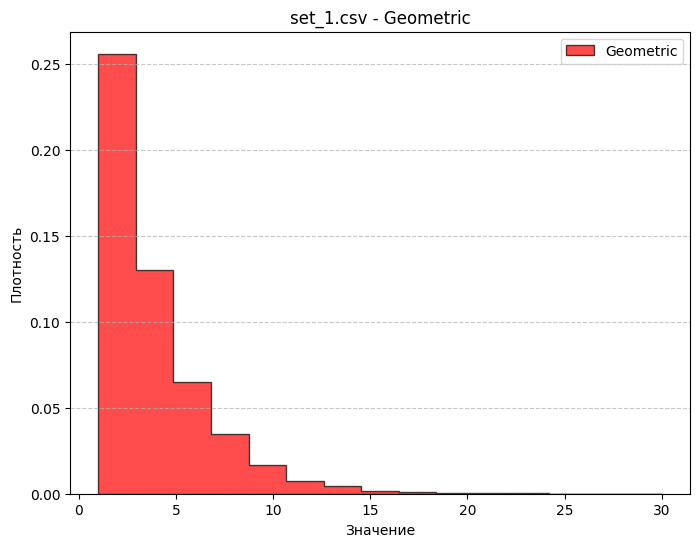

Биномиальное распределение недоступно: некорректные параметры
  Binomial: пустой массив (пропускаем гистограмму).
  Poisson: 10000 значений сгенерировано.


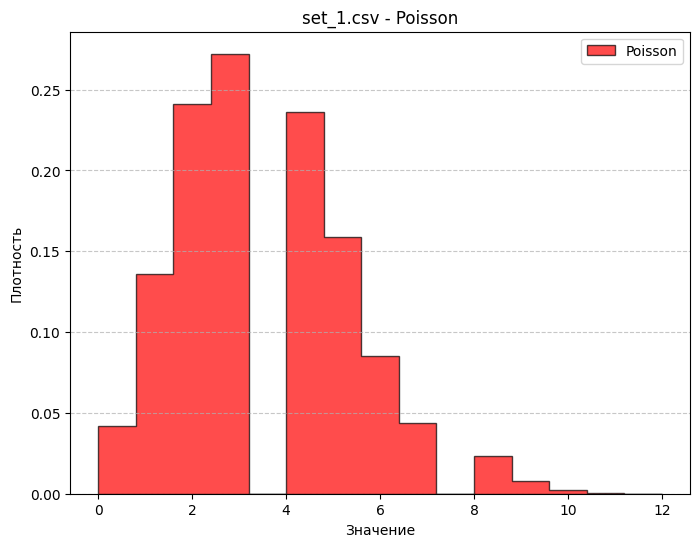

  Uniform: 10000 значений сгенерировано.


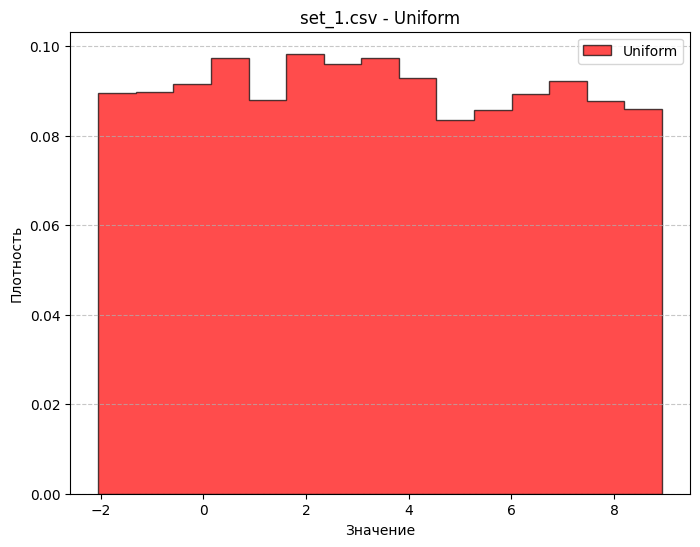

  Normal: 10000 значений сгенерировано.


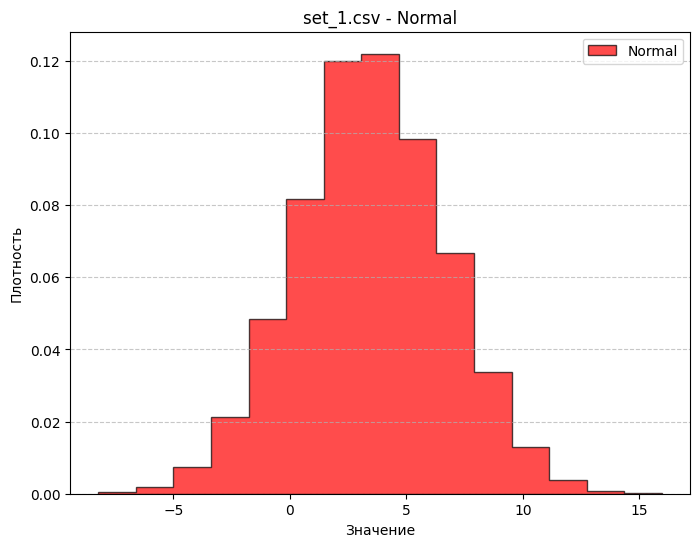

  Exponential: 10000 значений сгенерировано.


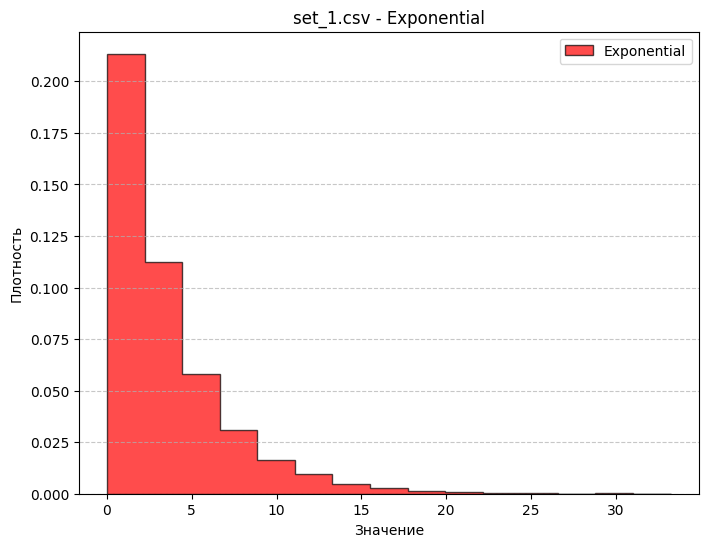


set_2.csv: Эмпирические параметры - mean = 16.2433, variance = 10928.4975
  Geometric: 10000 значений сгенерировано.


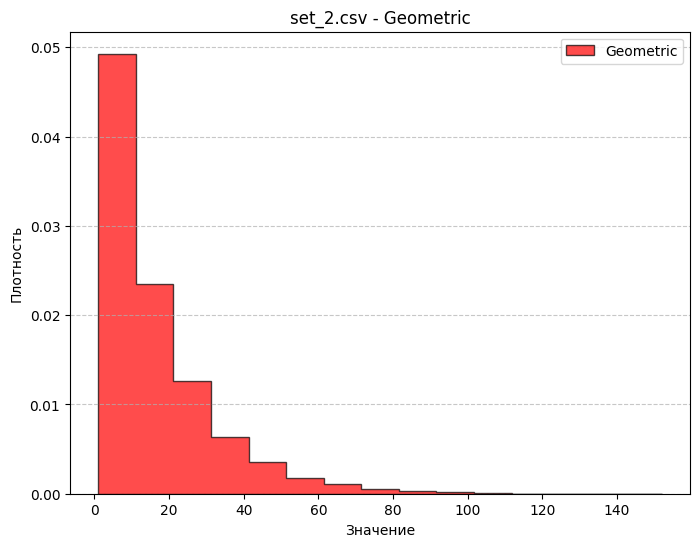

Биномиальное распределение недоступно: некорректные параметры
  Binomial: пустой массив (пропускаем гистограмму).
  Poisson: 10000 значений сгенерировано.


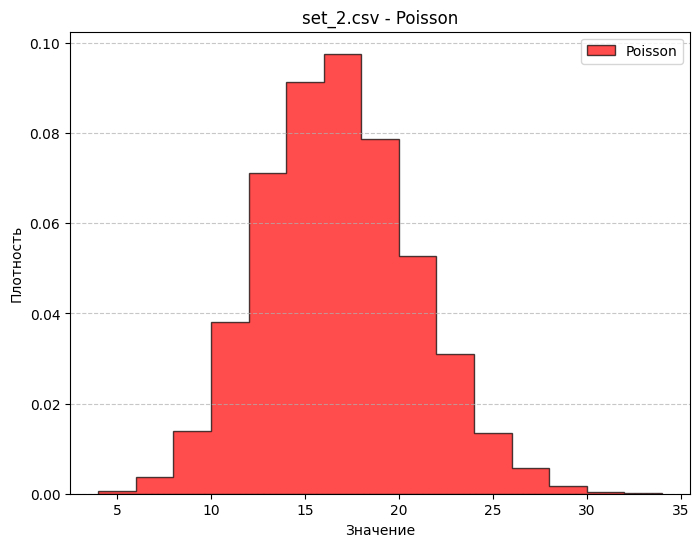

  Uniform: 10000 значений сгенерировано.


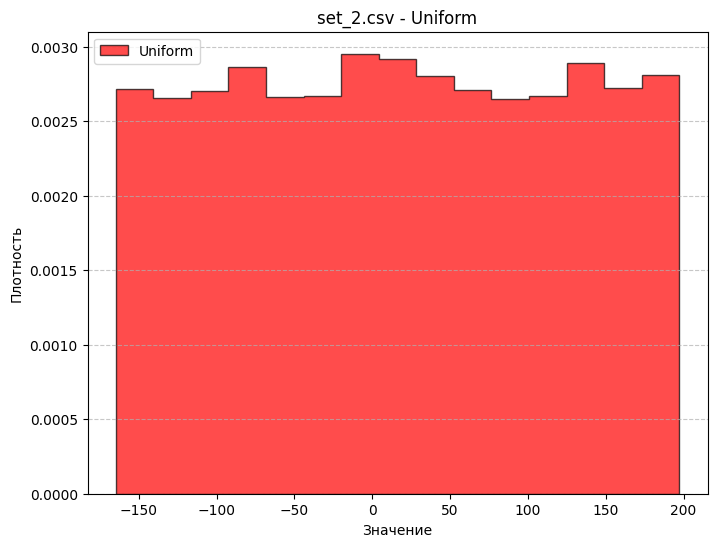

  Normal: 10000 значений сгенерировано.


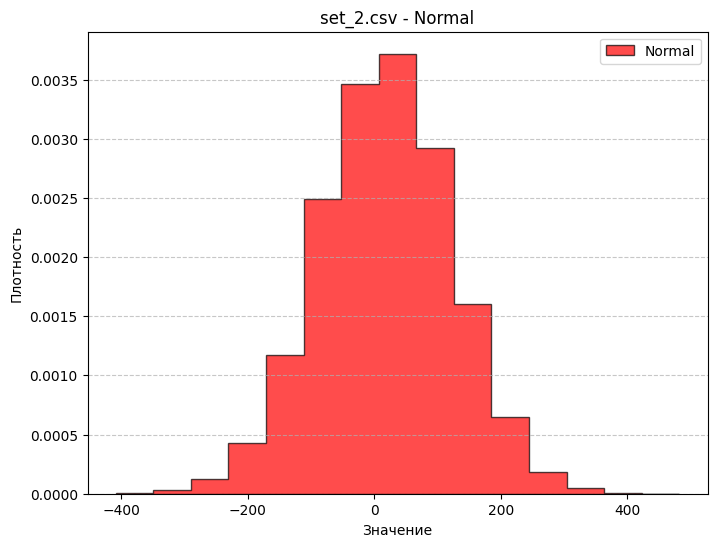

  Exponential: 10000 значений сгенерировано.


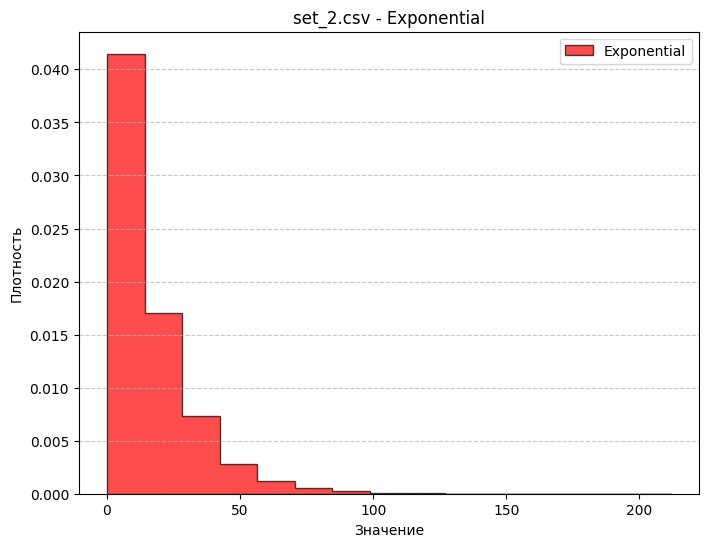


set_3.csv: Эмпирические параметры - mean = 0.1245, variance = 0.0256
Геометрическое распределение недоступно: mean <= 0 или mean < 1
  Geometric: пустой массив (пропускаем гистограмму).
Для биномиального распределения биномиальные значения равны 0
  Binomial: пустой массив (пропускаем гистограмму).
  Poisson: 10000 значений сгенерировано.


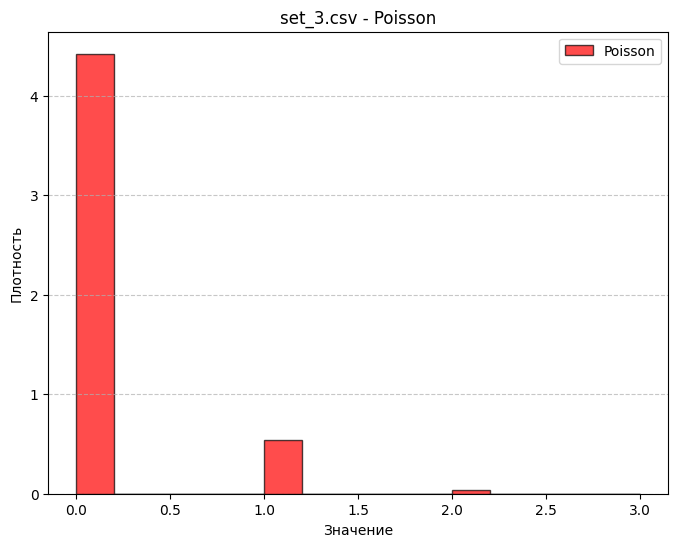

  Uniform: 10000 значений сгенерировано.


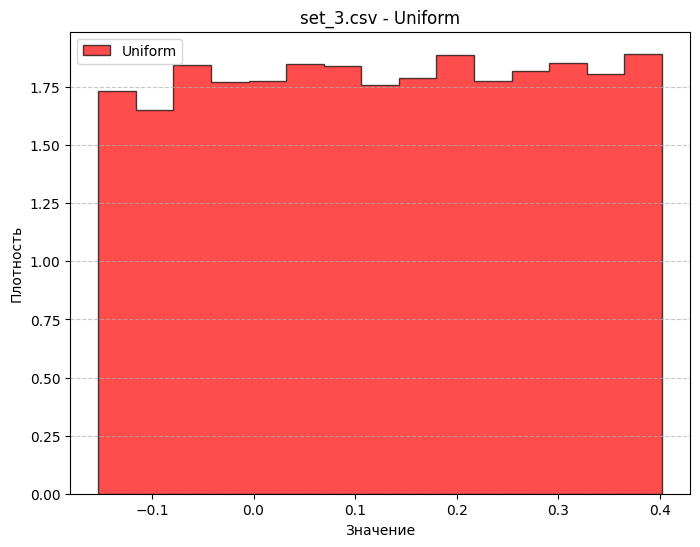

  Normal: 10000 значений сгенерировано.


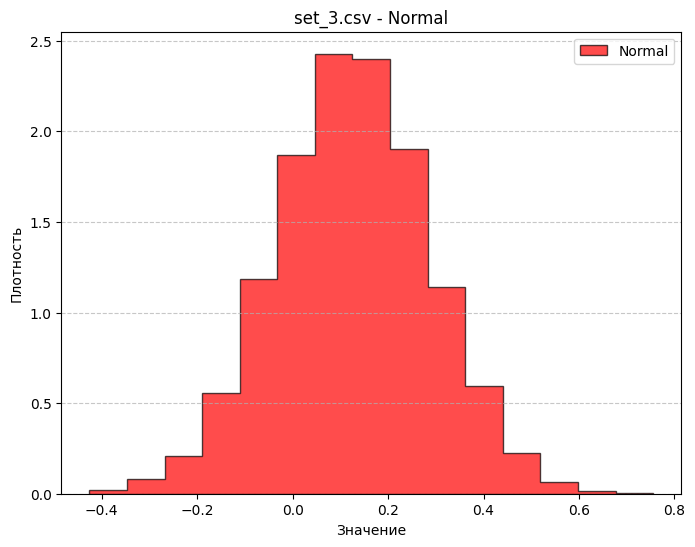

  Exponential: 10000 значений сгенерировано.


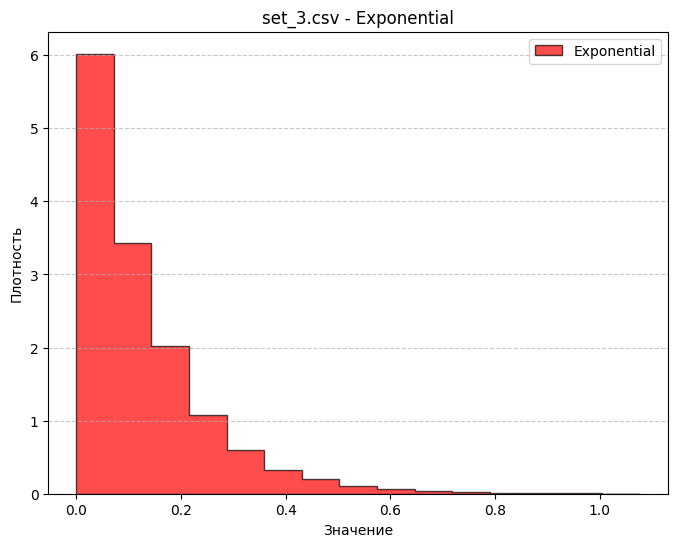

In [ ]:
# Функции генерации (из mean, variance):
def geometric_distribution(mean, variance, size=10000):
    if mean <= 0 or mean < 1:
        print("Геометрическое распределение недоступно: mean <= 0 или mean < 1")
        return np.array([])
    p = 1.0 / mean
    geometric_values = []
    for _ in range(size):
        count = 1
        while np.random.rand() > p:
            count += 1
        geometric_values.append(count)
    return np.array(geometric_values)

def binomial_distribution(mean, variance, size=10000):
    if mean <= 0 or variance < 0 or variance >= mean:
        print("Биномиальное распределение недоступно: некорректные параметры")
        return np.array([])
    p = 1 - (variance / mean)
    if p <= 0 or p >= 1:
        print("Биномиальное распределение недоступно: p не в (0,1)")
        return np.array([])
    n = int(round(mean / p))
    binomial_values = []
    for _ in range(size):
        trials = np.random.rand(n)
        successes = np.sum(trials < p)
        binomial_values.append(successes)
    if np.all(binomial_values == np.int64(0)):
        print("Для биномиального распределения биномиальные значения равны 0")
        return np.array([])
    return np.array(binomial_values)

def poisson_distribution(mean, variance, size=10000):
    if mean <= 0:
        print("Пуассоновское распределение недоступно: mean <= 0")
        return np.array([])
    poisson_values = []
    for _ in range(size):
        count = 0
        p = np.exp(-mean)
        F = p
        U = np.random.rand()
        while U >= F:
            p = p * mean / (count + 1)
            F = F + p
            count += 1
        poisson_values.append(count)
    return np.array(poisson_values)

def uniform_distribution(mean, variance, size=10000):
    if variance < 0:
        print("Равномерное распределение недоступно: variance < 0")
        return np.array([])
    std_dev = np.sqrt(variance)
    low = mean - std_dev * np.sqrt(3)
    high = mean + std_dev * np.sqrt(3)
    if low >= high:
        print("Равномерное распределение недоступно: low >= high")
        return np.array([])
    uniform_values = np.random.rand(size) * (high - low) + low
    return uniform_values

def normal_distribution(mean, variance, size=10000):
    if variance < 0:
        print("Нормальное распределение недоступно: variance < 0")
        return np.array([])
    std_dev = np.sqrt(variance)
    normal_values = []
    for _ in range(size):
        u1 = u2 = w = 0
        while w >= 1 or w == 0:
            u1 = 2 * np.random.rand() - 1
            u2 = 2 * np.random.rand() - 1
            w = u1**2 + u2**2
        w = np.sqrt((-2 * np.log(w)) / w)
        z1 = u1 * w
        x = mean + std_dev * z1
        normal_values.append(x)
    return np.array(normal_values)

def exponential_distribution(mean, variance, size=10000):
    if mean <= 0:
        print("Экспоненциальное распределение недоступно: mean <= 0")
        return np.array([])
    exponential_values = []
    for _ in range(size):
        u = np.random.rand()
        x = -mean * np.log(1 - u)
        exponential_values.append(x)
    return np.array(exponential_values)

distributions = {
    "Geometric": geometric_distribution,
    "Binomial": binomial_distribution,
    "Poisson": poisson_distribution,
    "Uniform": uniform_distribution,
    "Normal": normal_distribution,
    "Exponential": exponential_distribution
}

# Для каждого датасета генерируем выборку по каждому теоретическому распределению
# и строим одиночные гистограммы.

print("\nСравнение с теоретическими распределениями (одиночные гистограммы):")
for idx, (fname, df) in enumerate(dfs.items()):
    data_empirical = df["Value"]
    mean_val = data_empirical.mean()
    var_val = data_empirical.var()

    print(f"\n{fname}: Эмпирические параметры - mean = {mean_val:.4f}, variance = {var_val:.4f}")

    # Строим для каждого распределения отдельно
    for dist_name, func in distributions.items():
        sample = func(mean_val, var_val, size=10000)

        # Проверяем на пустоту
        if len(sample) == 0:
            print(f"  {dist_name}: пустой массив (пропускаем гистограмму).")
            continue

        # Проверяем на совпадение min и max (все элементы равны)
        if np.min(sample) == np.max(sample):
            unique_val = sample[0]
            print(f"  {dist_name}: все {len(sample)} значений равны {unique_val:.4f} (пропускаем гистограмму).")
            continue

        title = f"{fname} - {dist_name}"
        print(f"  {dist_name}: {len(sample)} значений сгенерировано.")

        # Одиночная гистограмма теоретической выборки
        plot_multi_histograms(
            data_list=[sample],
            title=title,
            labels=[dist_name],
            alpha_list=[0.7]
        )


# Шаг 7. Сравнение теоретических распределений с эмпирическими гистограммами

Для каждого набора данных:

1. Построить гистограмму эмпирических данных.
2. Сгенерировать выборку для каждого теоретического распределения на основе вычисленных параметров (среднее, дисперсия и др.).
3. Наложить гистограммы теоретических выборок на эмпирическую гистограмму.
4. Визуально определить, какое распределение лучше описывает данные.


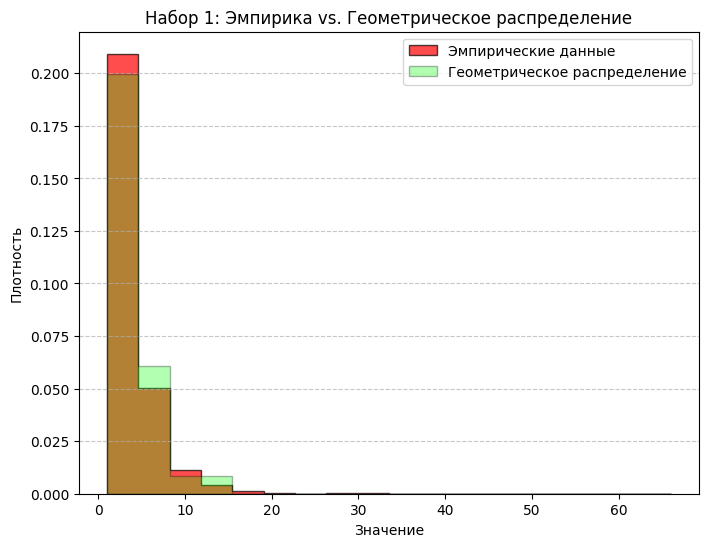

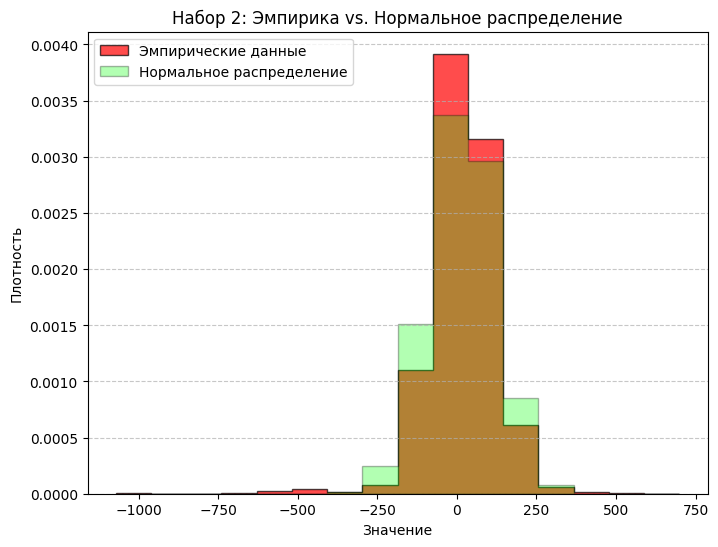

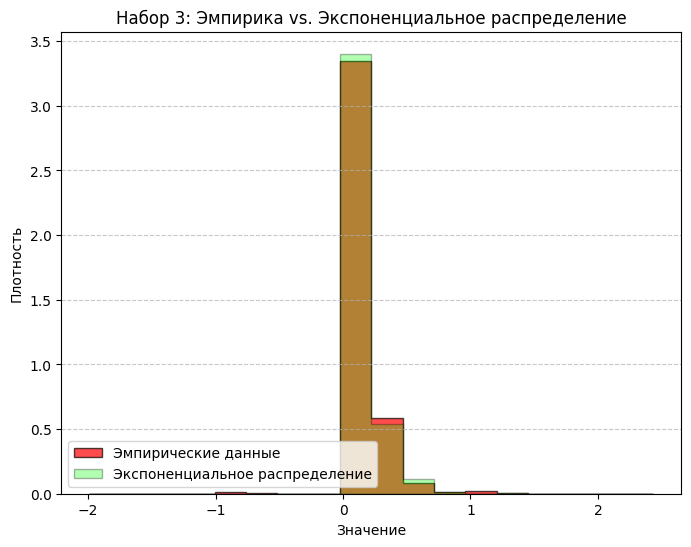

In [ ]:
if len(datasets) >= 3:
    # 1) Геометрическое
    mean0, var0 = mean_variance[0]
    data_emp0 = datasets[0]
    theo_sample0 = geometric_distribution(mean0, var0, size=100)
    plot_multi_histograms(
        data_list=[data_emp0, theo_sample0],
        title="Набор 1: Эмпирика vs. Геометрическое распределение",
        labels=["Эмпирические данные", "Геометрическое распределение"],
        alpha_list=[0.7, 0.3],
    )

    # 2) Нормальное
    mean1, var1 = mean_variance[1]
    data_emp1 = datasets[1]
    theo_sample1 = normal_distribution(mean1, var1, size=10000)
    plot_multi_histograms(
        data_list=[data_emp1, theo_sample1],
        title="Набор 2: Эмпирика vs. Нормальное распределение",
        labels=["Эмпирические данные", "Нормальное распределение"],
        alpha_list=[0.7, 0.3],
    )

    # 3) Экспоненциальное
    mean2, var2 = mean_variance[2]
    data_emp2 = datasets[2]
    theo_sample2 = exponential_distribution(mean2, var2, size=1000)
    plot_multi_histograms(
        data_list=[data_emp2, theo_sample2],
        title="Набор 3: Эмпирика vs. Экспоненциальное распределение",
        labels=["Эмпирические данные", "Экспоненциальное распределение"],
        alpha_list=[0.7, 0.3],
    )
